# Data Mining Project
### Giorgio Donati, g.donati24@studenti.unipi.it
### Pietro Francaviglia, p.francaviglia1@studenti.unipi.it
#### A.Y. 2021-2022


## Libraries and datasets

In [1]:
import itertools
from sklearn import tree
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier

from t3_constants import *
from t3_utility import *

In [2]:
with open(f'{PICKLE_FOLDER}{LABELLED}{USER_DF}.pkl', 'rb') as f:
    u_df = pickle.load(f)

In [3]:
p_df = u_df[[ICNT, AIXB, PSUM]]
p_a, p_df = scale_df(p_df, 1)
p_df[WLAB] = p_df[ICNT] + p_df[AIXB] + p_df[PSUM]
p_df[LAB] = rankings(p_df[WLAB], 1, 8)
p_df[LAB] = p_df[LAB].map({0:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2})
p_df.groupby(LAB).describe()

item_count                                                              \
           count      mean       std       min       25%       50%       75%   
label                                                                          
0          294.0 -0.887578  0.399286 -2.407901 -1.114085 -0.816987 -0.627707   
1          293.0  0.033602  0.375554 -0.960744 -0.256334  0.035973  0.285152   
2          196.0  1.281136  0.851737 -0.155703  0.797887  1.106965  1.520267   

                avg_items_per_basket            ... total_price            \
            max                count      mean  ...         75%       max   
label                                           ...                         
0      0.045557                294.0 -0.772949  ...   -0.553536  0.265168   
1      1.109361                293.0 -0.005650  ...    0.263666  1.290074   
2      7.185503                196.0  1.167869  ...    1.464961  5.945153   

         all                                                              \
       count      mean       std       min       25%       50%       75%   
label                                                                      
0      294.0 -2.486879  0.990668 -6.111661 -3.129806 -2.354049 -1.636774   
1      293.0  0.016575  0.773349 -1.191957 -0.649848  0.046993  0.664775   
2      196.0  3.705539  2.467618  1.570300  2.232774  3.077602  4.239451   

                  
             max  
label             
0      -1.199438  
1       1.555062  
2      20.475785  

[3 rows x 32 columns]

<AxesSubplot:ylabel='Frequency'>

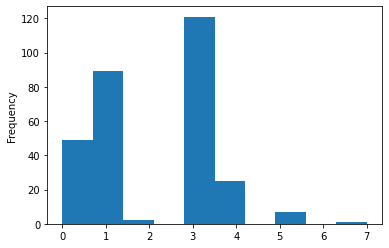

In [4]:
u_df[WLAB] = p_df[LAB]
u_df[u_df[WLAB] == 0][LAB].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

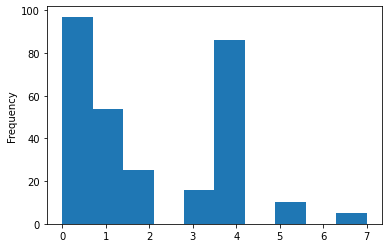

In [5]:
u_df[u_df[WLAB] == 1][LAB].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

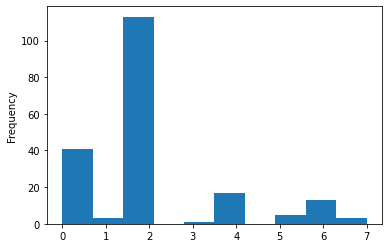

In [6]:
u_df[u_df[WLAB] == 2][LAB].plot(kind='hist')

In [7]:
u_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783 entries, 1 to 823
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   item_count                      783 non-null    int64  
 1   item_dist_count                 783 non-null    int64  
 2   max_items_per_b                 783 non-null    int64  
 3   shop_entropy                    783 non-null    float64
 4   category_entropy                783 non-null    float64
 5   item_entropy                    783 non-null    float64
 6   price_entropy                   783 non-null    float64
 7   max_item_dist_per_b             783 non-null    int64  
 8   total_price                     783 non-null    float64
 9   basket_count                    783 non-null    int64  
 10  category_count                  783 non-null    int64  
 11  shop_count                      783 non-null    int64  
 12  avg_items_per_basket            783 

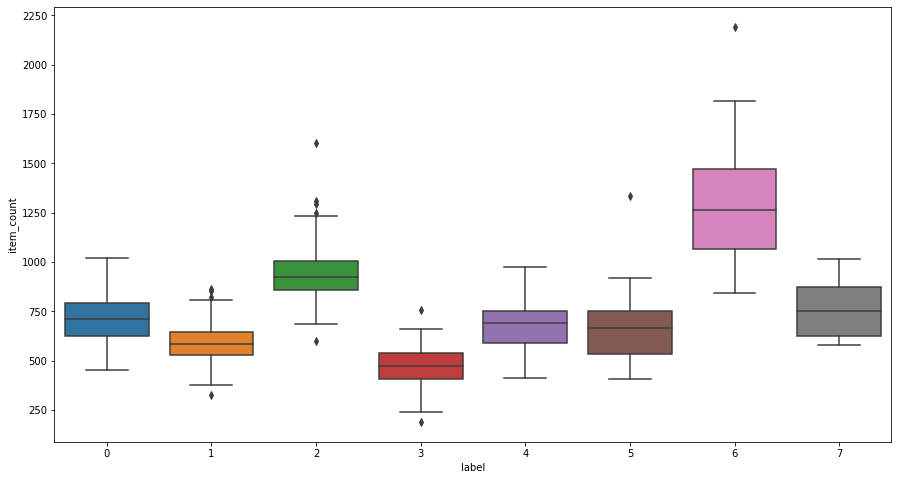

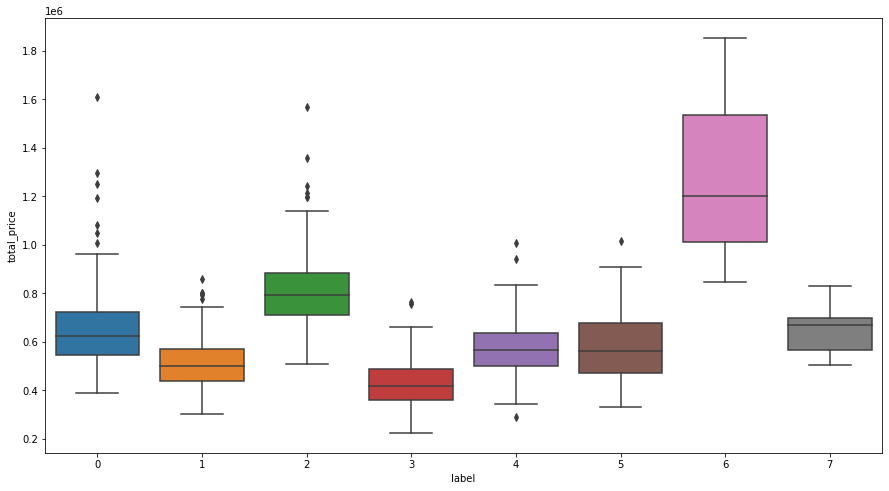

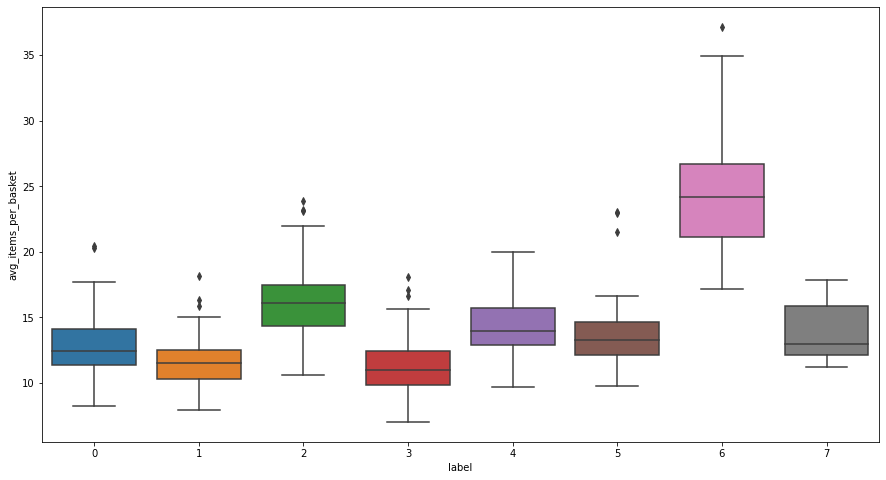

In [8]:
for c in [ICNT, PSUM, AIXB]:
    _, ax = plt.subplots(figsize=(15,8))
    sns.boxplot(x=LAB, y=c, data=u_df)

In [9]:
### spending label
# High spending 2, 6
# Medium spending 0, 4, 5, 7
# Low spending 1, 3

u_df[SLAB] = MS
u_df.loc[u_df[LAB].isin([2, 6]), SLAB] = HS
u_df.loc[u_df[LAB].isin([1, 3]), SLAB] = LS

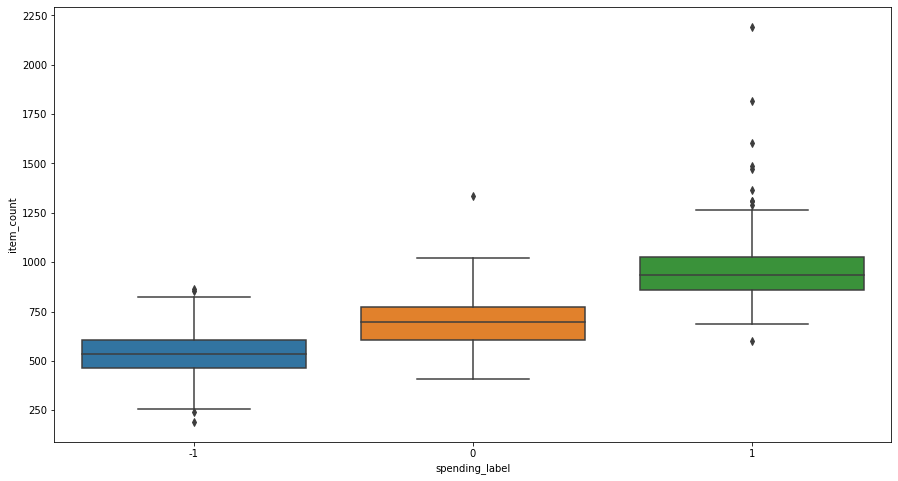

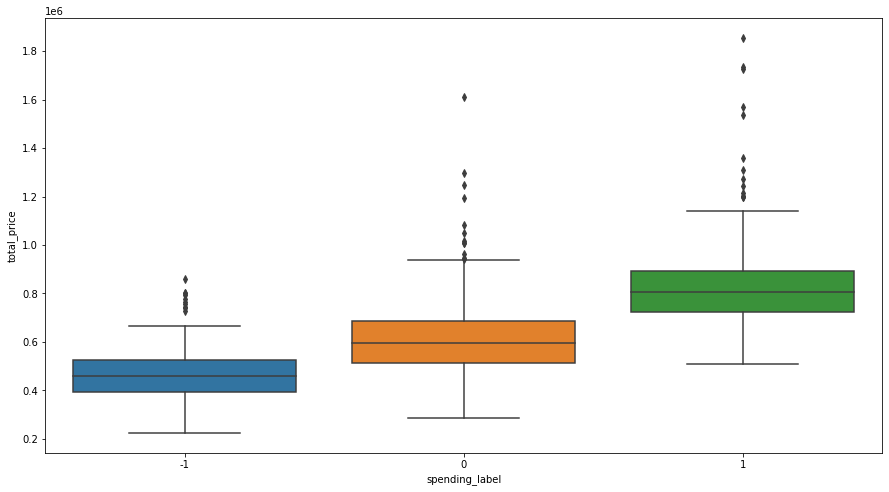

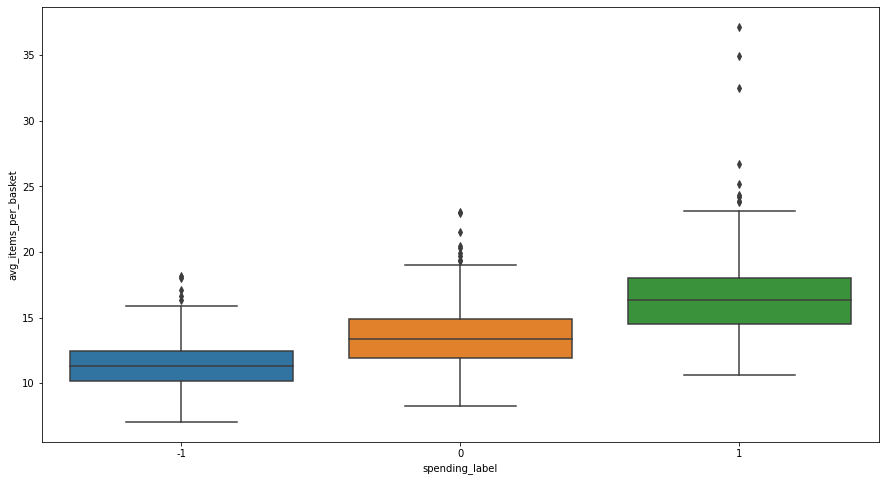

In [10]:
for c in [ICNT, PSUM, AIXB]:
    _, ax = plt.subplots(figsize=(15,8))
    sns.boxplot(x=SLAB, y=c, data=u_df)

In [11]:
u_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783 entries, 1 to 823
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   item_count                      783 non-null    int64  
 1   item_dist_count                 783 non-null    int64  
 2   max_items_per_b                 783 non-null    int64  
 3   shop_entropy                    783 non-null    float64
 4   category_entropy                783 non-null    float64
 5   item_entropy                    783 non-null    float64
 6   price_entropy                   783 non-null    float64
 7   max_item_dist_per_b             783 non-null    int64  
 8   total_price                     783 non-null    float64
 9   basket_count                    783 non-null    int64  
 10  category_count                  783 non-null    int64  
 11  shop_count                      783 non-null    int64  
 12  avg_items_per_basket            783 

In [12]:
train_x, test_x, train_y, test_y = train_test_split(
    u_df.drop(columns=[WLAB, LAB, SLAB]),
    u_df[SLAB],
    test_size=0.2,
    stratify=u_df[SLAB])
x = train_x.values
y = train_y.values.ravel().astype(int)

In [13]:
def cross_validation(model, X: np.ndarray, y: np.ndarray, n_splits: int) -> np.ndarray:
    """Return validation scores across the k folds of cross-validation."""
    skf = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)
    val_score = []
    for train_index, test_index in skf.split(X, y):
        model.fit(X[train_index], y[train_index].ravel())
        val_score.append(model.score(X[test_index], y[test_index].ravel() + 1))
    return np.array(val_score)

def cross_validation_summary(model, X: np.ndarray, y: np.ndarray, n_splits: int) -> np.ndarray:
    """Returns validation accuracy score of model (mean and std over all the splits)."""
    val_score = cross_validation(model, X, y, n_splits)
    return val_score.mean(), val_score.std()


In [14]:
## Hyper-parameters grid search for Decision Tree

hyp_dict = {
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': [0, 1, 1e-1, 1e-2, 1e-3, 1e-4],
    'min_samples_leaf': [1, 3, 5]
}
combinations = itertools.product(*(hyp_dict[key] for key in sorted(hyp_dict)))

results = []

for criterion, min_impurity_decrease, min_samples_leaf in combinations:
    model = tree.DecisionTreeClassifier(
        criterion=criterion,
        min_impurity_decrease=min_impurity_decrease,
        min_samples_leaf=min_samples_leaf,
        random_state=0
    )
    mean_val_score, std_val_score = cross_validation_summary(model, x, y, 3)
    res = criterion, min_impurity_decrease, min_samples_leaf, mean_val_score, std_val_score
    results.append(res)

decision_tree_results_df = pd.DataFrame(results, columns=['criterion', 'min_impurity_decrease', 'min_samples_leaf', 'mean_val_score', 'std_val_score'])
decision_tree_results_df.sort_values('mean_val_score')

,criterion,min_impurity_decrease,min_samples_leaf,mean_val_score,std_val_score
17,gini,0.0001,5,0.075098,0.019352
2,gini,0.0000,5,0.075098,0.019352
14,gini,0.0010,5,0.075098,0.019352
13,gini,0.0010,3,0.078257,0.009710
1,gini,0.0000,3,0.079860,0.008020
16,gini,0.0001,3,0.079860,0.008020
28,entropy,0.0100,3,0.092596,0.031475
33,entropy,0.0001,1,0.094191,0.033582
30,entropy,0.0010,1,0.094191,0.033582
18,entropy,0.0000,1,0.094191,0.033582


In [15]:
decision_tree_results_df.groupby('criterion').mean()

,min_impurity_decrease,min_samples_leaf,mean_val_score,std_val_score
criterion,,,,
entropy,0.185183,3.0,0.158484,0.023269
gini,0.185183,3.0,0.143428,0.020688


[Text(0.5, 0.875, 'item_count <= 768.5\nentropy = 1.511\nsamples = 626\nvalue = [227, 277, 122]'),
 Text(0.25, 0.625, 'category_count <= 45.5\nentropy = 1.111\nsamples = 432\nvalue = [226, 198, 8]'),
 Text(0.125, 0.375, 'natural_average_item_ranking <= 2.131\nentropy = 0.842\nsamples = 259\nvalue = [189, 70, 0]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'natural_average_item_ranking <= 2.231\nentropy = 1.003\nsamples = 173\nvalue = [37, 128, 8]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'max_item_dist_per_b <= 83.5\nentropy = 1.018\nsamples = 194\nvalue = [1, 79, 114]'),
 Text(0.625, 0.375, 'natural_average_basket_ranking <= 4.473\nentropy = 0.868\nsamples = 64\nvalue = [1, 49, 14]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'avg_baskets_per_d <= 1.292\nentropy = 0.779\nsamples = 130\nvalue = [0, 30, 100]'),
 Text(0.

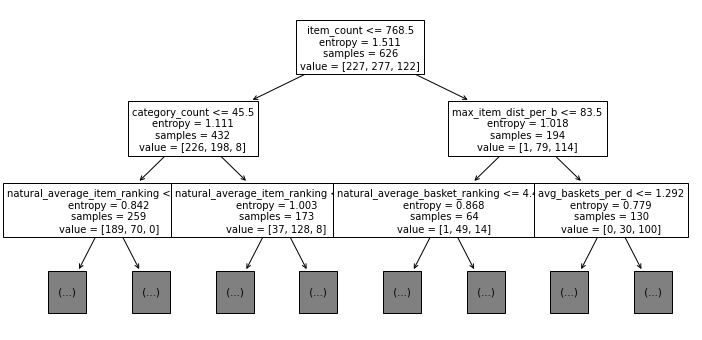

In [16]:
model = tree.DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.01, min_samples_leaf=1, random_state=0)
model.fit(x, y)
plt.figure(figsize=(12, 6))
tree.plot_tree(model, fontsize=10, max_depth=2, feature_names=train_x.columns)

In [17]:
pd.Series(model.feature_importances_, index = train_x.columns).sort_values()

natural_average_price_ranking     0.000000
item_dist_count                   0.000000
shop_entropy                      0.000000
item_entropy                      0.000000
avg_items_per_basket              0.008251
basket_count                      0.009367
total_price                       0.010163
max_items_per_b                   0.020591
natural_average_basket_ranking    0.023279
shop_count                        0.039695
avg_baskets_per_d                 0.043613
price_entropy                     0.058477
category_entropy                  0.069194
max_item_dist_per_b               0.090137
natural_average_item_ranking      0.120983
category_count                    0.121619
item_count                        0.384630
dtype: float64

# Ensembling

In [18]:
def randomized_cv(model, random_grid, n_iter=100):
    """Perform hyper-parameters grid search and return best configuration."""
    rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = n_iter, cv = 5, verbose=0, random_state=0, n_jobs = -1)

    # Run grid search
    rf_random.fit(x, y)
    mean_acc, std_acc = cross_validation_summary(rf_random.best_estimator_, x, y, 5)

    # Print configuration  and stats about best model
    print(f'{rf_random.best_estimator_}\n mean acc: {mean_acc:.3f}\n std_acc: {std_acc:.3f}')

## Random Forest

In [19]:
# Perform the hyper-parameters grid-search on random forest
random_grid = dict(
    n_estimators = np.logspace(1, 2.5, num=10).astype(int).tolist(),
    max_features = ['sqrt'],
    max_depth = [None] + np.logspace(0.5, 2, num=9).astype(int).tolist(),
    min_samples_split = [2, 5, 10],
    min_samples_leaf = [1, 2, 4],
    bootstrap = [True, False]
)
randomized_cv(
    model=RandomForestClassifier(random_state=0),
    random_grid=random_grid,
    n_iter=1000
)

KeyboardInterrupt: 